Syntax natürlicher Sprachen, WS 2023/24

# 08 - Übung (Lösung)

In [1]:
import nltk
from nltk.tree import Tree
from nltk.featstruct import FeatStruct
from nltk.featstruct import Feature, UnificationFailure, FeatStructReader
from sklearn.metrics import accuracy_score
import itertools

In [2]:
TYPE = nltk.featstruct.TYPE

def check_sanity_constraints(th):
    for type1, type2 in itertools.product(th, th):
        if type1 in th[type2] and type2 in th[type1]:
            if type1 != type2:
                raise ValueError(
                    "The type hierarchy is not antisymmetric! " +
                    "{} subsumes {} and vice versa!".format(
                        type1, type2
                    )
                )

def refl_trans_closure(type_hierarchy):
    # make everything a set
    # and compute reflexive closure
    closure = {}
    for t in type_hierarchy:
        closure[t] = set(type_hierarchy[t])
        closure[t].add(t)

    # compute transitive closure
    still_changes = True
    while still_changes:
        still_changes = False
        for x in closure:
            new_for_x = set()
            for y in closure[x]:
                for z in closure[y]:
                    new_for_x.add(z)
            len_before = len(closure[x])
            closure[x].update(new_for_x)
            still_changes |= len(closure[x]) > len_before

    return closure

class HierarchicalFeature(Feature):
    def __init__(self, name, type_hierarchy, **kwargs):
        super(HierarchicalFeature, self).__init__(name, **kwargs)

        self.hierarchy = refl_trans_closure(type_hierarchy)
        check_sanity_constraints(self.hierarchy)

    def unify_base_values(self, fval1, fval2, bindings):
        candidates = self.hierarchy[fval1].intersection(self.hierarchy[fval2])
        score = {t: 0 for t in candidates}
        for type1, type2 in itertools.product(candidates, candidates):
            if type1 in self.hierarchy[type2]:
                score[type1] += 1

        return min(candidates, key=score.__getitem__, default=UnificationFailure)

## Aufgabe 1 - Kasusrektion, Agreement und Subkategorisierung

### Welche der folgenden morphosyntaktischen Beschränkungen ist in den unteren Sätzen jeweils verletzt?

1. **Kasusrektion**
2. **Agreement** (nominale oder verbale Kongruenz)
3. **Subkategorisierung** (Anzahl und Art der verbalen Argumente)

(i)  *Ich beobachtet den Mond.*

In [ ]:
# Verbales Agreement (PERS:1 vs. PERS:3)

(ii)  *Ich beobachte dem Mond.*

In [ ]:
# Kasusrektion (CASE:dat statt CASE:akk für Objekt-NP)

(iii)  *Ich beobachte das Monde.*

In [ ]:
# nominales Agreement (GEN:neutr vs. GEN:mask, NUM:sg vs. NUM:pl)

(iii)  *Ich beobachte ihm den Mond.*

In [ ]:
# Subkategorisierung ('beobachten' hat kein indirektes Dativ-Objekt)

## Aufgabe 2 - Unifikation und Subsumption


### a) Stehen die beiden folgenden Merkmalstrukturen in einer Subsumptions- und/oder Unifikationsbeziehung? Wenn ja, geben Sie das Ergebnis der Subsumption bzw. Unifikation an, erläutern Sie andernfalls:


In [3]:
f0 = FeatStruct("[AGR=[NUM=sg]]") #allgemeiner
f1 = FeatStruct("[AGR=[NUM=sg, PERS=3]]") #spezifischer, mehr Informationen

In [4]:
#Subsumption (f0 ⊑ f1)
f0.subsumes(f1)

True

In [5]:
#Subsumption (f1 ⊑ f0)
f1.subsumes(f0)

False

In [6]:
#Unification (f0 ⊔ f1)
print(f0.unify(f1))

[ AGR = [ NUM  = 'sg' ] ]
[       [ PERS = 3    ] ]


### b) Stehen die beiden folgenden Merkmalstrukturen in einer Subsumptions- und/oder Unifikationsbeziehung? Wenn ja, geben Sie das Ergebnis der Subsumption bzw. Unifikation an, erläutern Sie andernfalls:


In [7]:
f0 = FeatStruct("[]") #allgemeinste feature structure (⊥ "bottom")
f1 = FeatStruct("[AGR=[NUM=sg, PERS=3]]")

In [8]:
#Subsumption (f0 ⊑ f1)
f0.subsumes(f1)

True

In [9]:
#Subsumption (f1 ⊑ f0)
f1.subsumes(f0)

False

In [10]:
#Unification (f0 ⊔ f1)
print(f0.unify(f1))

[ AGR = [ NUM  = 'sg' ] ]
[       [ PERS = 3    ] ]


### c) Stehen die beiden folgenden Merkmalstrukturen in einer Subsumptions- und/oder Unifikationsbeziehung? Wenn ja, geben Sie das Ergebnis der Subsumption bzw. Unifikation an, erläutern Sie andernfalls:


In [11]:
f0 = FeatStruct("[AGR=[NUM=sg, CASE=nom]]") 
f1 = FeatStruct("[AGR=[NUM=sg, PERS=3]]") 

In [12]:
#Subsumption (f0 ⊑ f1)
f0.subsumes(f1)
#keine Subsumption, da f0 auch Informationen enthält (CASE=nom), die nicht in f1 enthalten sind

False

In [13]:
#Subsumption (f1 ⊑ f0)
f1.subsumes(f0)
#keine Subsumption, da f1 auch Informationen enthält (PERS=3), die nicht in f0 enthalten sind

False

In [14]:
#Unification (f0 ⊔ f1)
print(f0.unify(f1))
#  Unifikation funktioniert aber, da Informationen nicht widersprüchlich
# d.h. auch Feature Structures, die nicht in Subsumption-Beziehung stehen, können unifizieren

[       [ CASE = 'nom' ] ]
[ AGR = [ NUM  = 'sg'  ] ]
[       [ PERS = 3     ] ]


In [15]:
# Unifikation als kleinste obere Schranke in der Subsumptionsbeziehung: f0 ⊑ (f0 ⊔ f1), f1 ⊑ (f0 ⊔ f1)
f0_f1_unified = f0.unify(f1)
print(f0.subsumes(f0_f1_unified))
print(f1.subsumes(f0_f1_unified)) 

True
True


### d) Stehen die beiden folgenden Merkmalstrukturen in einer Subsumptions- und/oder Unifikationsbeziehung? Wenn ja, geben Sie das Ergebnis der Subsumption bzw. Unifikation an, erläutern Sie andernfalls:


In [16]:
f0 = FeatStruct("[AGR=[NUM=pl]]") 
f1 = FeatStruct("[AGR=[NUM=sg, PERS=3]]")

In [17]:
#Subsumption (f0 ⊑ f1)
f0.subsumes(f1)

False

In [18]:
#Subsumption (f1 ⊑ f0)
f1.subsumes(f0)

False

In [19]:
#Unification (f0 ⊔ f1)
print(f0.unify(f1))

# nicht-unifizierende Merkmale
# Erläuterung: Unifikation nur partielle Ordnung, nicht immer definiert bei widersprüchlichen/unvereinbaren Werten

None


## Aufgabe 3 - Unifikation

#### Gegeben seien folgende Merkmalstrukturen:

In [20]:
f1 = FeatStruct(
    '[Vorname=Max, Nachname=Mustermann,' + 
    'Privat=[Strasse=Hauptstrasse, Ort=[Stadt=Muenchen]]]'
)
f2 = FeatStruct(
    '[Arbeit=[Strasse="Oettingenstrasse", Ort=(1)[Stadt=Muenchen]],' +
    'Privat=[Ort->(1)]]')
f3 = FeatStruct(
    '[Strasse="Hauptstrasse"]'
)
f4 = FeatStruct(
    '[Privat=[Strasse="Hauptstrasse", Ort=[Stadt=Passau]]]'
)

### a) Unifizieren f1 und f2? Gegeben Sie ggf. das Ergebnis an.

In [21]:
print(f1)

[ Nachname = 'Mustermann'                         ]
[                                                 ]
[            [ Ort     = [ Stadt = 'Muenchen' ] ] ]
[ Privat   = [                                  ] ]
[            [ Strasse = 'Hauptstrasse'         ] ]
[                                                 ]
[ Vorname  = 'Max'                                ]


In [22]:
print(f2)

[          [ Ort     = (1) [ Stadt = 'Muenchen' ] ] ]
[ Arbeit = [                                      ] ]
[          [ Strasse = 'Oettingenstrasse'         ] ]
[                                                   ]
[ Privat = [ Ort -> (1) ]                           ]


In [ ]:
# ja

In [8]:
#### Mit der Ausführung des print-Statements können Sie abschließend die Lösung einsehen:
print(f1.unify(f2))

[            [ Ort     = (1) [ Stadt = 'Muenchen' ] ] ]
[ Arbeit   = [                                      ] ]
[            [ Strasse = 'Oettingenstrasse'         ] ]
[                                                     ]
[ Nachname = 'Mustermann'                             ]
[                                                     ]
[ Privat   = [ Ort     -> (1)           ]             ]
[            [ Strasse = 'Hauptstrasse' ]             ]
[                                                     ]
[ Vorname  = 'Max'                                    ]


### b) Unifizieren f2 und f4? Gegeben Sie ggf. das Ergebnis an.

In [23]:
print(f2)

[          [ Ort     = (1) [ Stadt = 'Muenchen' ] ] ]
[ Arbeit = [                                      ] ]
[          [ Strasse = 'Oettingenstrasse'         ] ]
[                                                   ]
[ Privat = [ Ort -> (1) ]                           ]


In [24]:
print(f4)

[          [ Ort     = [ Stadt = 'Passau' ] ] ]
[ Privat = [                                ] ]
[          [ Strasse = 'Hauptstrasse'       ] ]


In [ ]:
# nein

In [25]:
#### Mit der Ausführung des print-Statements können Sie abschließend die Lösung einsehen:
print(f2.unify(f4))

None


## Aufgabe 4 - Typhierarchie

#### Gegeben sei folgende Typhierarchie, die ein kombiniertes Person-Numerus-Agreement-Feature als hierarchisch durch Subsumptionsbeziehung gegliederte Featurewerte  modelliert ([1] ⊑ [1sg] usw.).


In [26]:
type_hierarchy = {
    "1": ["1sg","1pl"],
    "2": ["2sg", "2pl"],
    "3": ["3sg", "3pl"],
    "sg": ["1sg", "2sg", "3sg"],
    "pl": ["1pl", "2pl", "3pl"],
    "1sg": [],
    "1pl": [],
    "2sg": [],
    "2pl": [],
    "3sg": [],
    "3pl": [],
}
AGR = HierarchicalFeature("AGR", type_hierarchy)
reader = FeatStructReader(features=(AGR,))

### a) Geben Sie eine (nicht-leere) Merkmalstruktur `f1` aus der Typhierarchie an, sodass gilt:

`f1` subsumiert `f0`.

In [30]:
f0 = reader.fromstring("[*AGR*='1sg']") #strings containing numbers have to be marked as strings
f1 = reader.fromstring("[*AGR*='1']")
f1.subsumes(f0)

True

In [31]:
f0.subsumes(f1)

False

In [32]:
f1.subsumes(f0)

True

In [33]:
print(f0.unify(f1))

[ *AGR* = '1sg' ]


### b) Geben Sie zwei (nicht-leere) Merkmalstrukturen `f1` und `f2` aus der Typhierarchie an, sodass gilt:

- `f1` subsumiert NICHT `f0`
- `f0` subsumiert  NICHT `f1`
- aber `f1` und `f0` sind unifizierbar.

In [34]:
f0 = reader.fromstring("[*AGR*='1']")
f1 = reader.fromstring("[*AGR*=sg]")
print(f1.subsumes(f0), f0.subsumes(f1))

False False


#### Unifikation als kleinste obere Schranke in der Subsumptionsbeziehung:

In [35]:
#Unification (f0 ⊔ f1)
print(f0.unify(f1))

#f0 ⊑ (f0 ⊔ f1), hier: 1 ⊑ (1sg)
#f1 ⊑ (f0 ⊔ f1), hier: sg ⊑ (1sg)

[ *AGR* = '1sg' ]


### c) Geben Sie zwei (nicht-leere) Merkmalstrukturen `f1` und `f2` aus der Typhierarchie an, sodass gilt:

- `f1` subsumiert NICHT `f0`
- `f0` subsumiert  NICHT `f1`
- und `f1` und `f0` sind NICHT unifizierbar.

In [37]:
f0 = reader.fromstring("[*AGR*='1sg']")
f1 = reader.fromstring("[*AGR*='2sg']")
print(f1.subsumes(f0), f0.subsumes(f1))

False False


In [38]:
print(f0.unify(f1))

None


## *Aufgabe 5 - Getypte Merkmalstrukturen in CFG*

#### Gegeben sei folgende Typhierarchie:

$$\bot \sqsubseteq \text{Genitiv}$$
$$\bot \sqsubseteq \text{nicht-Genitiv}$$
$$\text{nicht-Genitiv} \sqsubseteq \text{Nominativ-Akkusativ}$$
$$\text{nicht-Genitiv} \sqsubseteq \text{Dativ}$$
$$\text{Nominativ-Akkusativ} \sqsubseteq \text{Nominativ}$$
$$\text{Nominativ-Akkusativ} \sqsubseteq \text{Akkusativ}$$


### a) Implementieren Sie ein Feature `CASE`, das der vorgegebenen Typhierarchie entspricht.

#### Hier muss die Typhierarchie in Form eines Dictionary definiert werden:

In [39]:
type_hierarchy = {
    "nonGen": ["NomAkk", "Dat"],
    "NomAkk": ["Nom", "Akk"],
    "Dat": [],
    "Akk": [],
    "Gen": [],
    "Nom": []
}

In [40]:
CASE = HierarchicalFeature("CASE", type_hierarchy)
reader = FeatStructReader(features=(CASE,))

### b) Geben Sie eine (nicht-leere) Merkmalstruktur `f1`  aus der Typhierarchie an, sodass gilt:

`f1` subsumiert NICHT `f0`.

In [41]:
f0 = reader.fromstring("[*CASE*=NomAkk]")
f1 = reader.fromstring("[*CASE*=Nom]")
f1.subsumes(f0)

False

In [42]:
f0.subsumes(f1)

True

In [43]:
print(f0.unify(f1))

[ *CASE* = 'Nom' ]


### c) Nutzen Sie das getypte `CASE`-Feature nun, um Übergenerierung in folgender Grammatik zu vermeiden:

In [44]:
grammar = """
S -> NP[*CASE*=Nom] VP
NP[*CASE*=?x] -> DET[*CASE*=?x,GEN=?y] NOM[*CASE*=?x,GEN=?y]
NOM[*CASE*=?x,GEN=?y] -> N[*CASE*=?x,GEN=?y] NP[*CASE*=Gen] | N[*CASE*=?x,GEN=?y]
VP -> V

V -> "schläft"
DET[GEN=mask,*CASE*=Nom] -> "der"
DET[GEN=mask,*CASE*=Gen] -> "des"
DET[GEN=fem,*CASE*=NomAkk] -> "die"
DET[GEN=fem,*CASE*=Gen] -> "der"
DET[GEN=fem,*CASE*=Dat] -> "der"
DET[GEN=neut,*CASE*=NomAkk] -> "das"
DET[GEN=neut,*CASE*=Gen] -> "des"

N[GEN=mask,*CASE*=nonGen] -> "Mann"
N[GEN=mask,*CASE*=Gen] -> "Mannes"
N[GEN=fem] -> "Frau"
N[GEN=neut,*CASE*=nonGen] -> "Kind"
N[GEN=neut,*CASE*=Gen] -> "Kindes"
"""

In [45]:
CASE = HierarchicalFeature("CASE", type_hierarchy)
compiled_grammar = nltk.grammar.FeatureGrammar.fromstring(
    grammar, features=(CASE, TYPE)
)
parser = nltk.FeatureEarleyChartParser(compiled_grammar)

#### Folgendes sollte funktionieren:

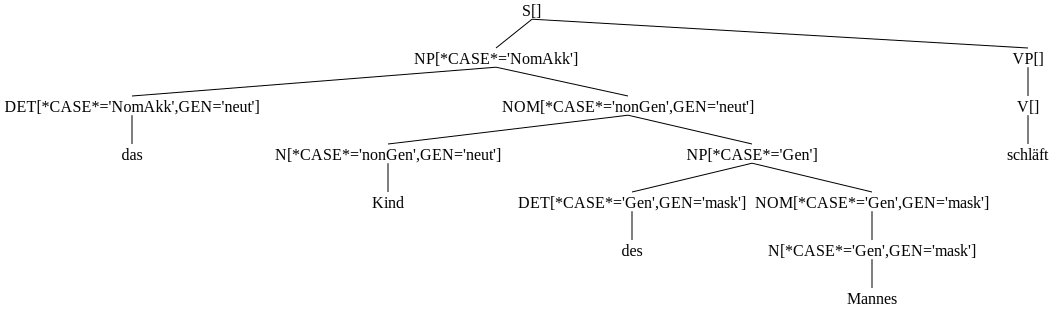

In [46]:
for t in parser.parse("das Kind des Mannes schläft".split()):
    t = Tree.fromstring(str(t).replace(", ",","))
#    t.pretty_print(unicodelines=True)
    display(t)

#### Folgendes sollte leer sein:

In [47]:
list(parser.parse("des Mannes schläft".split()))

[]

## *Aufgabe 6: Nominale Kongruenz*
#### Betrachten Sie die folgenden Sätze. Offensichtlich besteht zwischen Artikel und Nomen einer Nominalphrase Kongruenz im Genus.

  
1. - *Der Löffel ist aus Silber.*
   - *&ast; Der Gabel ist aus Silber.*
   - *&ast; Der Messer ist aus Silber.* <p>
    
2. - *&ast; Die Löffel ist aus Silber.* 
   - *Die Gabel ist aus Silber.*
   - *&ast; Die Messer ist aus Silber.* <p>
   
3. - *&ast; Das Löffel ist aus Silber.*
   - *&ast; Das Gabel ist aus Silber.*
   - *Das Messer ist aus Silber.*

### a) Nutzen Sie Merkmalstrukturen in einem Python-Skript zur Überprüfung dieser Kongruenz. Ihr Skript sollte alle untenstehenden Beispiele korrekt als grammatisch/ungrammatisch klassifizieren können.


In [48]:
test_cases = [
    (det, noun)
    for det in ["der", "die", "das"]
    for noun in ["Löffel", "Gabel", "Messer"]
]
truth = [
    True, False, False,
    False, True, False,
    False, False, True
]

In [49]:
test_cases

[('der', 'Löffel'),
 ('der', 'Gabel'),
 ('der', 'Messer'),
 ('die', 'Löffel'),
 ('die', 'Gabel'),
 ('die', 'Messer'),
 ('das', 'Löffel'),
 ('das', 'Gabel'),
 ('das', 'Messer')]

In [50]:
#Lösung Teil 1: Feature-Structures
lexicon = {
    "der": FeatStruct(GEN="mask",NUM="sg"),
    "die": FeatStruct(GEN="fem"),
    "das": FeatStruct(GEN="neutr",NUM="sg"),
    "Messer": FeatStruct(CAT="N", GEN="neutr"),
    "Gabel": FeatStruct(CAT="N", GEN="fem"),
    "Löffel": FeatStruct(CAT="N", GEN="mask")
}

In [51]:
print(lexicon["der"].unify(lexicon["Löffel"]))

[ CAT = 'N'    ]
[ GEN = 'mask' ]
[ NUM = 'sg'   ]


In [52]:
print(lexicon['das'].unify(lexicon['Löffel']))

None


In [53]:
#Lösung Teil 2: Kongruenz-Überprüfung durch Unifikation

def is_correct(det, noun):
    # return lexicon[det] == lexicon[noun]
    return lexicon[det].unify(lexicon[noun]) is not None

In [54]:
# Evaluation
pred = []
for nomPhr in test_cases:
    pred.append(is_correct(*nomPhr))

print("Accuracy: {:.2f} %".format(accuracy_score(truth, pred)*100))

Accuracy: 100.00 %


### b) Durch den Satzkontext haben wir bisher erzwungen, dass Numerus und Kasus der Beispiele immer konstant waren (Singular, Nominativ). Lassen wir diese Einschränkung weg, ergeben sich noch weitere grammatische Kombinationsmöglichkeiten.

| - | Messer | Gabel | Löffel
| --- | ----------------- | ----------------- | ----------------- |
| der | Pl. Gen. | Sg. Gen./Dat. | Sg. Nom./Pl. Gen. |
| des | * | * | * |
| dem | Sg. Dat. | * | Sg. Dat. |
| den | * | * | Sg. Akk. |
| die | Pl. Nom./Akk. | Sg. Nom./Akk. | Pl. Nom./Akk. |
| das | Sg. Nom./Akk. | * | * |

#### Betrachten Sie das folgende mit Merkmalstrukturen implementierte Vollformlexikon. Schreiben Sie darauf aufbauend ein Programm, dass alle 18 Kombinationen aus obenstehender Tabelle als grammatisch oder ungrammatisch klassifiziert und im ersten Fall die unifizierte(n) Merkmalstruktur(en) ausgibt.

In [55]:
lexicon = {
    "Messer": [
        FeatStruct(GEN="neu", NUM="sg", KAS="nom"),
        FeatStruct(GEN="neu", NUM="sg", KAS="akk"),
        FeatStruct(GEN="neu", NUM="sg", KAS="dat"),
        FeatStruct(GEN="neu", NUM="pl", KAS="nom"),
        FeatStruct(GEN="neu", NUM="pl", KAS="akk"),
        FeatStruct(GEN="neu", NUM="pl", KAS="gen")
    ],
    "Gabel": [FeatStruct(GEN="fem", NUM="sg")], #KAS-unterspezifiziert (alle 4 KAS-Feature möglich):
    
#    "Gabel": [
#        FeatStruct(GEN="fem", NUM="sg", KAS="nom"),
#        FeatStruct(GEN="fem", NUM="sg", KAS="gen"),
#        FeatStruct(GEN="fem", NUM="sg", KAS="dat"),
#        FeatStruct(GEN="fem", NUM="sg", KAS="akk")
#    ],

    "Löffel": [
        FeatStruct(GEN="mas", NUM="sg", KAS="nom"),
        FeatStruct(GEN="mas", NUM="sg", KAS="akk"),
        FeatStruct(GEN="mas", NUM="sg", KAS="dat"),
        FeatStruct(GEN="mas", NUM="pl", KAS="nom"),
        FeatStruct(GEN="mas", NUM="pl", KAS="akk"),
        FeatStruct(GEN="mas", NUM="pl", KAS="gen"),
    ],

    "der": [
        FeatStruct(NUM="sg", GEN="mas", KAS="nom"),
        FeatStruct(NUM="sg", GEN="fem", KAS="dat"),
        FeatStruct(NUM="sg", GEN="fem", KAS="gen"),
        FeatStruct(NUM="pl", KAS="gen")
    ],
    "des": [
        FeatStruct(NUM="sg", GEN="mas", KAS="gen"),
        FeatStruct(NUM="sg", GEN="neu", KAS="gen")
    ],
    "dem": [
        FeatStruct(NUM="sg", GEN="mas", KAS="dat"),
        FeatStruct(NUM="sg", GEN="neu", KAS="dat"),
    ],
    "den": [
        FeatStruct(NUM="sg", GEN="mas", KAS="akk"),
        FeatStruct(NUM="pl", KAS="dat"),
    ],
    "die": [
        FeatStruct(NUM="sg", GEN="fem", KAS="nom"),
        FeatStruct(NUM="sg", GEN="fem", KAS="akk"),
        FeatStruct(NUM="pl", KAS="nom"),
        FeatStruct(NUM="pl", KAS="akk")
    ],
    "das": [
        FeatStruct(NUM="sg", GEN="neu", KAS="nom"),
        FeatStruct(NUM="sg", GEN="neu", KAS="akk"),
    ]
}

In [56]:
def predict(artikel, nomen):
    for art_fs in lexicon[artikel]:
        for nom_fs in lexicon[nomen]:
            if art_fs.unify(nom_fs):
                return True
    return False

In [57]:
test_cases = [
    (det, noun)
    for det in ["der", "des", "dem", "den", "die", "das"]
    for noun in ["Messer", "Löffel", "Gabel"]
]
truth = [
    True, True, True,
    False, False, False,
    True, True, False,
    False, True, False,
    True, True, True,
    True, False, False
]

predictions = []
for artikel, nomen in test_cases:
    predictions.append(predict(artikel, nomen))

print(
    "Accuracy: {:.0f}%".format(
        accuracy_score(truth, predictions)*100
    )
)

Accuracy: 100%
